<a href="https://colab.research.google.com/github/Narusi/My-Projects/blob/master/Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22411 sha256=afe1ec3386dd980118b27cc21a5729d64d8e884c581689c8102b75b844caaeb3
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
import yfinance as yf

import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt

In [0]:
asset = 'MSFT'
stock = yf.Ticker(asset)
data = stock.history(period='max', auto_adjust=False)
brief = stock.info

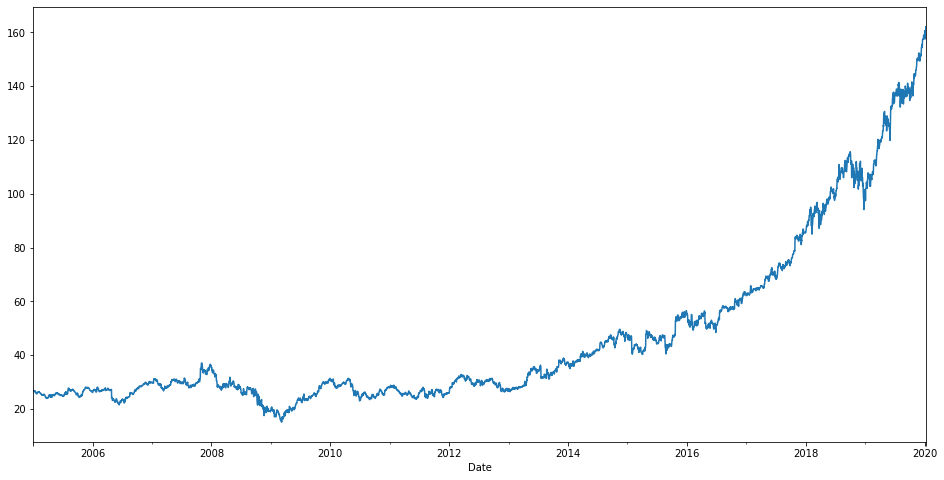

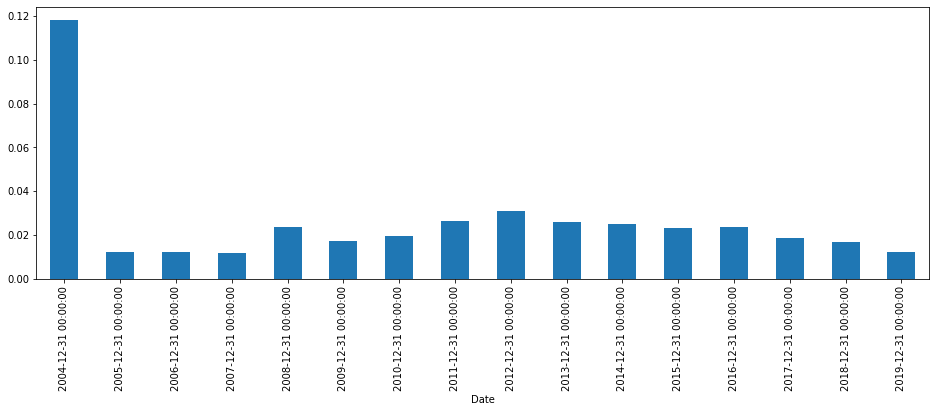

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Yield
Date,,,,,,,,,
2020-01-06,157.08,159.10,156.51,159.03,159.03,20813700.0,0.0,0.0,0.0
2020-01-07,159.32,159.67,157.32,157.58,157.58,21634100.0,0.0,0.0,0.0
2020-01-08,158.93,160.80,157.95,160.09,160.09,27746500.0,0.0,0.0,0.0
2020-01-09,161.84,162.22,161.03,162.09,162.09,21385000.0,0.0,0.0,0.0
2020-01-10,162.82,163.22,161.18,161.34,161.34,16885562.0,0.0,0.0,0.0


In [0]:
data = data.sort_index().resample('D').last()
data = data[data['Open'] != 0.0]

data[['Open','High','Low','Close','Adj Close']] = data[['Open','High','Low','Close','Adj Close']].fillna(method='ffill')
data['Yield'] = data['Dividends'].fillna(method='ffill').div(data['Close']).fillna(0.0)
data[['Volume','Dividends','Stock Splits']] = data[['Volume','Dividends','Stock Splits']].fillna(0.0)
data = data.dropna()

close = data['Close']
close['2005':].plot(figsize=(16,8))
plt.show();

divYields = data['Dividends'].resample('A').sum().div(data['Close'].asfreq(freq='A', method='ffill'))
divYields = divYields.dropna().asfreq(freq='A', method='ffill')
divYields['2004':].plot(kind='bar', figsize=(16,5))
plt.show();

data.tail()

# Momentum strategy

## Momentum signals


In [0]:
def momentumBuy(close, asset='Asset', step=50, output='current', chart=False, printOut=False):
    shortBuy = close > close.rolling(step).mean()
    mediumBuy = close > close.rolling(step * 2).mean()
    longBuy = close > close.rolling(step * 4).mean()

    medMBuy = close.rolling(step).mean() > close.rolling(step * 2).mean()
    longMBuy = close.rolling(step).mean() > close.rolling(step * 4).mean()

    veryLongBuy = close.rolling(step * 2).mean() > close.rolling(200).mean()

    buySignals = pd.DataFrame(index=close.index)

    buySignals['BuySS'] = shortBuy
    buySignals['BuySM'] = mediumBuy
    buySignals['BuySL'] = longBuy
    buySignals['BuyMM'] = medMBuy
    buySignals['BuyML'] = longMBuy
    buySignals['BuyLL'] = veryLongBuy

    ts = pd.DataFrame({asset:close.div(close.iloc[0]),
                    'Returns':np.log(close/close.shift(1)),
                    'BuySignal':buySignals.sum(axis=1)},
                    index=close.index)

    momSum = ts.groupby('BuySignal')['Returns'].sum()
    momMed = ts.groupby('BuySignal')['Returns'].median()
    buySigns = []
    holdSignal = []
    sellSign = []
    losingSignals = momSum[momSum <= 0.0].index

    for bl in range(len(buySignals.columns),0,-1):        
        if np.logical_and(momSum[bl] > 0.0, bl > max(losingSignals)):
            buySigns.append(bl)
        elif momSum[bl] > 0.0:
            holdSignal.append(bl)
        elif momMed[bl] <= 0.0:
            sellSign.append(bl)

    ts['Signal'] = ''
    ts.loc[ts[ts['BuySignal'] == 0].index, 'Signal'] = 'SELL'
    
    if len(buySigns) > 1:
        for buy in buySigns:
            ts.loc[ts[ts['BuySignal'] == buy].index, 'Signal'] = 'BUY'
    elif len(buySigns) == 1:
        ts.loc[ts[ts['BuySignal'] == buySigns[0]].index, 'Signal'] = 'BUY'
        
    if len(holdSignal) > 1:
        for hold in holdSignal:
            ts.loc[ts[ts['BuySignal'] == hold].index, 'Signal'] = 'HOLD'
    elif len(holdSignal) == 1:
        ts.loc[ts[ts['BuySignal'] == holdSignal[0]].index, 'Signal'] = 'HOLD'

    if len(sellSign) > 1:
        for sell in sellSign:
            ts.loc[ts[ts['BuySignal'] == sell].index, 'Signal'] = 'SELL'
    elif len(sellSign) == 1:
        ts.loc[ts[ts['BuySignal'] == sellSign[0]].index, 'Signal'] = 'SELL'

    for b in buySignals.columns:    
        rets = ts['Returns'][buySignals[b]]
        prob = rets[rets > 0.0].count()/rets.count()    
        if printOut: print(b, prob, rets.mean());

        ts[b] = 0
        ts.loc[buySignals[buySignals[b]].index, b] = 1

    if chart:
        ts['2018':][[asset,'BuySignal']].plot(figsize=(16,8))
        plt.show();

    if printOut: print(ts.groupby('BuySignal')['Returns'].mean());
    
    for i in range(6):
        minpick = ts.loc[ts[ts['BuySignal'] >= i].index]
        probs = minpick.groupby('BuySignal')['Returns'].count()/minpick['Returns'].count()    
        rets = minpick.groupby('BuySignal')['Returns'].mean()
        std = minpick.groupby('BuySignal')['Returns'].std()

        dprobs = minpick[minpick['Returns'] < 0.0].groupby('BuySignal')['Returns'].count()/minpick.groupby('BuySignal')['Returns'].count()
        #print((probs * rets).sum())
        #print(dprobs)
    
    ts['LAG.14'] = ts['Returns'].shift(14).rolling(14).sum()
    ts['LAG.28'] = ts['Returns'].shift(28).rolling(28).sum()
    ts['LAG.60'] = ts['Returns'].shift(60).rolling(60).sum()
    ts['LAG.90'] = ts['Returns'].shift(90).rolling(90).sum()
    lags = ['LAG.14','LAG.28','LAG.60','LAG.90']
    
    signalProbs = pd.DataFrame(index=list(range(len(list(itertools.product([1, 0], 
                                                                           repeat = len(buySignals.columns)))))),
                               columns=list(buySignals.columns) + lags)
    signalProbs[buySignals.columns] = 0
    signalProbs[lags] = 0.0

    signalReturns = pd.DataFrame(index=list(range(len(list(itertools.product([1, 0], 
                                                                           repeat = len(buySignals.columns)))))),
                               columns=list(buySignals.columns) + lags)
    signalReturns[buySignals.columns] = 0
    signalReturns[lags] = 0.0

    i = 0
    for comb in itertools.product([1, 0], repeat = len(buySignals.columns)):
        comb = list(comb)
        signalProbs.loc[i, buySignals.columns] = comb

        signInd = buySignals[buySignals == comb].dropna().index
        signRets = ts[lags].reindex(signInd)
        theProbs = signRets[signRets > 0.05/28.0].count()/signRets.count()
        
        signalProbs.loc[i, lags] = theProbs
        signalReturns.loc[i, lags] = signRets.median()
        i += 1
    
    for ss in buySignals.columns:
        rets = ts[ts[ss] == 1][lags].dropna()
        prob = rets[rets > 0.01].count()/rets.count()
        hrets = rets[rets > 0.01].mean()

        if printOut:
            print('\n',ss)
            print(rets.mean(), '\n',rets.median())
            print('\nProbabilities:')
            print(prob.mean())
            print((prob * hrets).mean())
    
    if printOut: print(ts.groupby('Signal')['Returns'].mean());
    
    currentState = (np.array(signalProbs[buySignals.columns].values) == np.array(ts[buySignals.columns].iloc[-1].values)).sum(axis=1) == len(buySignals.columns)
    lagOutput = []
    for lagProb in lags:
        action = ''
        if signalProbs[currentState][lagProb].values[0] > 0.75: action = 'BUY'
        elif signalProbs[currentState][lagProb].values[0] > 0.50: action = 'HOLD'
        elif signalProbs[currentState][lagProb].values[0] <= 0.50: action = 'SELL'

        lagOutput.append([lagProb, action, 
                          signalProbs[currentState][lagProb].values[0], 
                          signalReturns[currentState][lagProb].values[0]])

        if printOut:
            print(lagProb, action, 
                  round(100*signalProbs[currentState][lagProb].values[0],1),
                  round(100*signalReturns[currentState][lagProb].values[0],3))
    
    if output == 'current':
        return lagOutput
    elif output == 'ts':
        return ts
    elif output == 'single':
        ttemp = pd.DataFrame(lagOutput)        
        return ttemp.loc[ttemp[2].idxmin(), 1]

a = 'MSFT'
prices = yf.download(a)['Adj Close']
timeSeries = momentumBuy(prices, asset=a, output='ts')
print('Current: ', timeSeries.iloc[-1]['BuySignal'])
print(timeSeries.groupby(['Signal','BuySignal'])['Returns'].mean())

pd.DataFrame(momentumBuy(prices, asset=a, output='current'))

[*********************100%***********************]  1 of 1 completed
Current:  6
Signal  BuySignal
BUY     5            0.000528
        6            0.003201
HOLD    1            0.000045
SELL    0           -0.002595
        2           -0.000176
        3           -0.001468
        4           -0.000362
Name: Returns, dtype: float64


,0,1,2,3
0,LAG.14,BUY,0.756098,0.031770
1,LAG.28,BUY,0.807927,0.057315
2,LAG.60,BUY,0.797561,0.083966
3,LAG.90,BUY,0.802134,0.106897


In [0]:
def featurize(x):
    ret = np.log(x/x.shift(30))
    mu = ret.mean()
    sigma = ret.std()
    
    ubnd = x * (1 + mu)
    lbnd = x * (1 - mu)
    
    y = np.zeros(shape=(len(x),1))
    y[x >= ubnd.shift(-30)] = 1
    y[x <= lbnd.shift(-30)] = -1
    
    #for i in range(-1,2,1):
    #    print(i, len(y[y==i])/len(y))
    
    X = pd.DataFrame(index=x.index)
    X['P'] = x
    X['P30'] = np.log(x/x.shift(30))
    X['50'] = x.rolling(50).mean()
    X['100'] = x.rolling(100).mean()
    X['200'] = x.rolling(200).mean()
    X['P/50'] = x/X['50']
    X['P/100'] = x/X['100']
    X['P/200'] = x/X['200']
    X['50/100'] = X['50']/X['100']
    X['100/200'] = X['100']/X['200']
    X['50/200'] = X['50']/X['200']
    
    X = X[['P30','P/50','P/100','P/200',
           '50/100','100/200','50/200']]
    X = X.fillna(0.0)
    
    return X, y.ravel()

In [0]:
def svmMom(X,y):
    from sklearn.svm import SVC
    clf = SVC(gamma='auto')
    clf.fit(X.iloc[:-200], y[:-200])

    pred = int(clf.predict(X.iloc[-1:])[0])
    predScore = clf.score(X.iloc[:-30],y[:-30])

    return pred, predScore

In [0]:
def rfcMom(X,y):
    from sklearn.ensemble import RandomForestClassifier

    clf = RandomForestClassifier()
    clf.fit(X.iloc[:-200],y[:-200])

    pred = int(clf.predict(X.iloc[-1:])[0])
    predScore = clf.score(X.iloc[:-30],y[:-30])

    return pred, predScore

In [0]:
def kncMom(X,y):
    from sklearn.neighbors import KNeighborsClassifier
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X.iloc[:-200],y[:-200])

    pred = int(clf.predict(X.iloc[-1:])[0])
    predScore = clf.score(X.iloc[:-30],y[:-30])

    return pred, predScore

In [0]:
def gbcMom(X,y):
    from sklearn.ensemble import GradientBoostingClassifier
    clf = GradientBoostingClassifier()
    clf.fit(X.iloc[:-200],y[:-200])

    pred = int(clf.predict(X.iloc[-1:])[0])
    predScore = clf.score(X.iloc[:-30],y[:-30])

    return pred, predScore

In [0]:
portfolio = ['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'ADI', 'AEP', 'AGM', 'AGNC',
             'ALB', 'AMTD', 'AMZN', 'APD', 'ARR', 'ATVI', 'AVAL', 'BABA', 'BAH',
             'BEN', 'BLK', 'C', 'CAH', 'CATY', 'CBT', 'CCBG', 'CCL', 'CFG',
             'CHD', 'CHRW', 'CL', 'CMA', 'CMCSA', 'CNI', 'COST', 'CSCO', 'CVS',
             'CVX', 'D', 'DDS', 'DUK', 'DX', 'EBF', 'EMR', 'ENB', 'EPD', 'EPR',
             'ES', 'FAST', 'FB', 'FDX', 'FITB', 'FLIC', 'FLO', 'FRT', 'FSLR',
             'GFI', 'GGG', 'GIS', 'GOLD', 'GOOG', 'GS', 'GWB', 'HBAN', 'HMY',
             'IBCP', 'IBM', 'IMBBY', 'INTC', 'IRBT', 'IRM', 'JNJ', 'JPM', 'K',
             'KEY', 'KMB', 'KO', 'LMT', 'LOW', 'MA', 'MAIN', 'MBWM', 'MCD',
             'MCY', 'MDP', 'MDT', 'MED', 'MMM', 'MMP', 'MO', 'MPLX', 'MSFT',
             'MSI', 'MSM', 'NFLX', 'NHI', 'NJR', 'NKE', 'NNN', 'NRIM', 'NTAP',
             'O', 'OC', 'OKE', 'OZK', 'PEBO', 'PEP', 'PFG', 'PG', 'PII', 'PLD',
             'PM', 'PNC', 'PRU', 'RCL', 'RF', 'RGLD', 'RNR', 'SBUX', 'SKT',
             'SNV', 'SO', 'SPG', 'STAG', 'SWM', 'TGT', 'TM', 'TSLA', 'TWO',
             'TXN', 'UHT', 'UNH', 'UNM', 'UVV', 'V', 'VGR', 'VOD', 'VZ', 'WBA',
             'WBS', 'WELL', 'WEN', 'WFC', 'WLK', 'WM', 'WMT', 'XOM', 'YORW',
             'SFG1T.TL']
    
prices = yf.download(portfolio)['2005':]['Adj Close']

for a in portfolio:
    try:
        signal = momentumBuy(prices[a], asset=a, output='single')
        if signal == 'BUY':
            print('Recomendation for {} is to {}'.format(a, signal))
    except:
        print('Failed to load ',a)

[*********************100%***********************]  148 of 148 completed
Recomendation for AEP is to BUY
Recomendation for MA is to BUY
Recomendation for MAIN is to BUY
Recomendation for MSFT is to BUY
Failed to load  SFG1T.TL


In [0]:
for a in portfolio:
    X, y = featurize(prices[a])
    ps = []
    scores = []

    svmp, svms = svmMom(X,y)
    rfcp, rfcs = rfcMom(X,y)
    kncp, kncs = kncMom(X,y)
    gbcp, gbcs = gbcMom(X,y)

    if svms >= 0.65: 
        ps.append(svmp)
        scores.append(round(svms,2))
    if rfcs >= 0.65: 
        ps.append(rfcp)
        scores.append(round(rfcs,2))
    if kncs >= 0.65: 
        ps.append(kncp)
        scores.append(round(kncs,2))
    if gbcs >= 0.65: 
        ps.append(gbcp)
        scores.append(round(gbcs,2))

    if sum(ps) >= len(ps) - 1: 
        print(a, 'BUY', ps, scores)

ADBE BUY [1, 1, 1] [0.97, 0.86, 0.77]
ARR BUY [1, 1, 1] [0.94, 0.88, 0.85]
BEN BUY [1, 1, 1] [0.98, 0.89, 0.83]
BLK BUY [1, 1, 1] [0.97, 0.87, 0.76]
COST BUY [1, 1, 1] [0.97, 0.84, 0.73]
CVS BUY [1, 0, 1] [0.98, 0.87, 0.77]
DUK BUY [1, 1, 1] [0.97, 0.85, 0.75]
EMR BUY [1, 1, 1] [0.97, 0.85, 0.76]
ES BUY [1, 1, 1] [0.97, 0.87, 0.75]
FDX BUY [1, 1, 1] [0.97, 0.89, 0.82]
FITB BUY [1, 1, 1] [0.98, 0.91, 0.81]
HMY BUY [1, 1, 1] [0.97, 0.91, 0.82]
JPM BUY [1, 1, 1] [0.98, 0.86, 0.76]
MBWM BUY [1, 1, 1] [0.97, 0.88, 0.83]
MDP BUY [1, 1, 1] [0.98, 0.91, 0.86]
MMM BUY [1, 1, 1] [0.97, 0.86, 0.79]
MO BUY [1, 1, 1] [0.98, 0.87, 0.76]
OZK BUY [1, 1, 1] [0.97, 0.88, 0.81]
PG BUY [1, 1, 1] [0.99, 0.88, 0.76]
PLD BUY [1, 1, 1] [0.97, 0.88, 0.8]
RGLD BUY [1, 1, 1] [0.96, 0.86, 0.75]
SKT BUY [1, 1, 1] [0.98, 0.86, 0.78]
TGT BUY [1, 1, 1] [0.97, 0.85, 0.76]
UHT BUY [1, 1, 1] [0.98, 0.83, 0.74]
VGR BUY [1, 1, 1] [0.97, 0.86, 0.75]
WBA BUY [1, 1, 1] [0.98, 0.89, 0.81]
WBS BUY [1, 1, 1] [0.97, 0.9, 0.82]
W

In [0]:
shortList = ['ABBV','TSLA','FB',
             'SO','T','MSFT']

for a in shortList:
    print(a)

    ts = pd.DataFrame({'P':prices[a]}, index=prices.index).dropna()
    ts['R'] = ts['P'].pct_change(30).shift(-30).fillna(0.0)
    
    rn = len(ts.index[:-252])
    if rn <= 200: rn = 201;

    ts['SVM'] = 0
    ts['RFC'] = 0
    ts['KNN'] = 0
    ts['GBC'] = 0
    models = ['SVM','RFC','KNN','GBC']

    ts['SVMh'] = 0
    ts['RFCh'] = 0
    ts['KNNh'] = 0
    ts['GBCh'] = 0
    
    for i in range(len(ts.index[rn:]),30,-1):
        ii = ts.index[-i]
        pp = ts['P'].iloc[:-i]
        ret = pp.iloc[30-i]/pp.iloc[-i] - 1
        X,y = featurize(pp)
        
        ts.iloc[-i,2] = svmMom(X,y)[0]
        ts.iloc[-i,3] = rfcMom(X,y)[0]
        ts.iloc[-i,4] = kncMom(X,y)[0]
        ts.iloc[-i,5] = gbcMom(X,y)[0]

        for m in models:
            if ts.loc[ii, m] * ts.loc[ii, 'R'] > 0.0:
                ts.loc[ii, str(m)+'h'] = 1
    
    print(ts.iloc[-1][models])

    hits = pd.Series(index=models)
    for c in models:
        try:
            r = ts[ts[c]==1]['R']
            hits[c] = len(r[r > 0.0].index)/len(r.index)
        except:
            print('Failed to get prob. for ',c)

    print('\n', hits, '\n************\n')

ABBV
SVM    0.0
RFC    0.0
KNN    0.0
GBC    0.0
Name: 2020-01-10 00:00:00, dtype: float64
Failed to get prob. for  SVM

 SVM         NaN
RFC    0.462963
KNN    0.408163
GBC    0.791667
dtype: float64 
************
TSLA
SVM    0.0
RFC    0.0
KNN    0.0
GBC    0.0
Name: 2020-01-10 00:00:00, dtype: float64

 SVM    1.000000
RFC    0.384615
KNN    0.150000
GBC    0.358974
dtype: float64 
************
FB
SVM    0.0
RFC    0.0
KNN    0.0
GBC    0.0
Name: 2020-01-10 00:00:00, dtype: float64
Failed to get prob. for  SVM

 SVM         NaN
RFC    0.413793
KNN    0.333333
GBC    0.360000
dtype: float64 
************
SO


In [0]:
for t in ['SVM','RFC','KNN','GBC']:
    res = (ts[ts[t]!=0]['R'] * ts[ts[t]!=0][t])
    print(t, res.mean(), res.median())
    
    for i in ts.index:
        if ts.loc[i, t] * ts.loc[i, 'R'] > 0.0:
            ts.loc[i, str(t) + 'h'] = 1

SVM -0.013406721167048693 -0.020491721499194204
RFC -0.013175766385431704 -0.02050481261229309
KNN -0.018612204877733296 -0.03299501787618753
GBC -0.014801522711686874 -0.019520122538670526


In [0]:
hits = ts[['SVMh','RFCh','KNNh','GBCh']]
ts[ts['RFC'] == 1]['SVMh'].mean()

models = ['SVM','RFC','KNN','GBC']
for a in models:
    hit = ts[ts[a] == 1][a+'h'].mean()
    print(a, round(hit,2))

ts.iloc[-1][models]

SVM nan
RFC 0.43
KNN 0.33
GBC 0.55


SVM    0.0
RFC    0.0
KNN    0.0
GBC    0.0
Name: 2020-01-10 00:00:00, dtype: float64